In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import *
from statsmodels.graphics.tsaplots import *
from catboost import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.datasets import load_diabetes
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.metrics import *
import pickle
import tensorflow as tf
import shap
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import *
import os

# 敏感性分析需要禁用v2_behavior
# tf.compat.v1.disable_v2_behavior()

forceCpu = False
# 使用CPU
if forceCpu:
    cpu = tf.config.list_physical_devices("CPU")
    tf.config.set_visible_devices(cpu)
    print(tf.config.list_logical_devices())

# 动态显存
if not forceCpu:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        print('Invalid device or cannot modify virtual devices once initialized')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, style='whitegrid', palette=palette)  # 解决Seaborn中文显示问题

D:\Users\win\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rawData = pd.read_excel('../../../preprocess/左侧填充-物流网络历史货量数据.xlsx')
rawData = pd.melt(rawData, id_vars=['场地1', '场地2'], value_name='货量', var_name='日期')
rawData.head()

,场地1,场地2,日期,货量
0,1,8,2021-01-01,3
1,2,3,2021-01-01,9
2,2,4,2021-01-01,2
3,2,5,2021-01-01,6
4,2,8,2021-01-01,2


In [3]:

filterSize = 7


def getxy():
    targetKey = '货量'
    # 对场地进行编码

    df = rawData.copy()
    # df = df[(df['场地1'] == 'DC14') & (df['场地2'] == 'DC10')].reset_index(drop=True)
    # df['场地1'] = df['场地1'].str.replace('DC', '')
    # df['场地1'] = df['场地1'].astype('int64')
    # df['场地2'] = df['场地2'].str.replace('DC', '')
    # df['场地2'] = df['场地2'].astype('int64')

    df['日期'] = pd.to_datetime(df['日期'])
    df['日期'] = df['日期'] - df['日期'].min()
    df['日期'] = df['日期'].apply(lambda x: x.days)

    df['货量'] = np.log(df['货量'])
    # return df.drop(targetKey, axis=1), df[targetKey], df

    grouped = df.groupby(['场地1', '场地2']).size().reset_index(name='count')
    merged = pd.merge(df, grouped, on=['场地1', '场地2'], how='left').reset_index(drop=True)
    ltSize = merged[merged['count'] < filterSize]
    print(f'总行数有：{df.shape}')
    print(f'数据小于{filterSize}的行数有：{ltSize.shape}')
    filtered = merged[merged['count'] >= filterSize]
    filtered = filtered.drop('count', axis=1)
    print(f'清洗后数量：{filtered.shape}')
    return filtered.drop(targetKey, axis=1), filtered[targetKey], filtered


# 读入数据
_, _, data = getxy()
data.head()

总行数有：(765770, 4)
数据小于7的行数有：(0, 5)
清洗后数量：(765770, 4)


,场地1,场地2,日期,货量
0,1,8,0,1.098612
1,2,3,0,2.197225
2,2,4,0,0.693147
3,2,5,0,1.791759
4,2,8,0,0.693147


In [4]:

# 将数据处理成模型可接受的形式
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # a = dataset[i:(i + look_back), :-1]
        # 自回归
        # a = dataset[i:(i + look_back), [0, 1, 3]]
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)


# 按照时间排序
data = data.sort_values('日期')

# 将每条有向边转换成一个序列
dataset = []
for _, group in data.groupby(['场地1', '场地2']):
    dataset.append(group.values)

print(f'dataset数量: {len(dataset)}')

# 将序列转换成模型可接受的形式
'''
`look_back`是一个超参数，它定义了我们在创建时间序列数据集时要考虑多少个时间步。
具体地说，对于每条有向边的货量时间序列，我们将数据集中的每个样本定义为过去`look_back`个时间步的货量，目标是预测下一个时间步的货量。

例如，
如果`look_back`设置为1，我们将使用过去1天的货量数据来预测下一天的货量。
如果`look_back`设置为3，我们将使用过去3天的货量数据来预测下一天的货量。
通过调整`look_back`，我们可以控制模型应该考虑多少历史数据来进行预测。
'''
look_back = filterSize - 1
trainX, trainY = [], []
for i in range(len(dataset)):
    train_x, train_y = create_dataset(dataset[i], look_back)
    trainX.append(train_x)
    trainY.append(train_y)

trainX, trainY = np.concatenate(trainX), np.concatenate(trainY)
ratio = int(len(trainX) * 0.9)
trainX, testX, trainY, testY = trainX[:], trainX[ratio:], trainY[:], trainY[ratio:]

print(f'trainX.shape: {trainX.shape}')
print(f'testX.shape: {testX.shape}')
print(f'trainY.shape: {trainY.shape}')
print(f'testY.shape: {testY.shape}')

dataset数量: 1049
trainX.shape: (759476, 6, 4)
testX.shape: (75948, 6, 4)
trainY.shape: (759476,)
testY.shape: (75948,)


In [5]:
trainX[0]

array([[1.        , 8.        , 0.        , 1.09861229],
       [1.        , 8.        , 1.        , 1.09861229],
       [1.        , 8.        , 2.        , 1.09861229],
       [1.        , 8.        , 3.        , 1.09861229],
       [1.        , 8.        , 4.        , 1.09861229],
       [1.        , 8.        , 5.        , 1.09861229]])

76/76 [==============================] - 3s 13ms/step


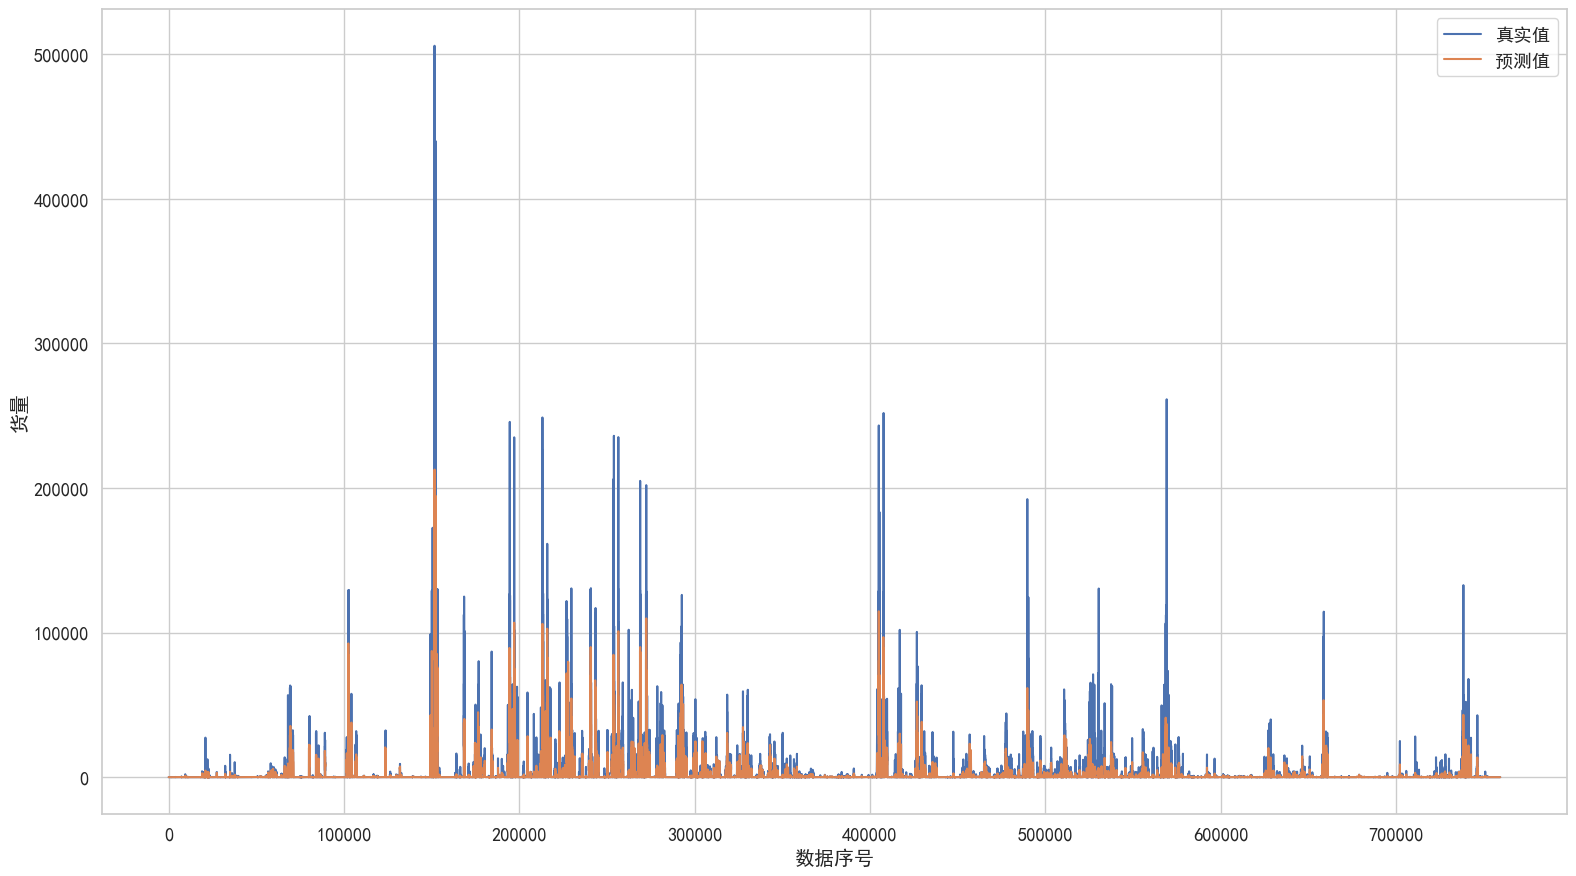

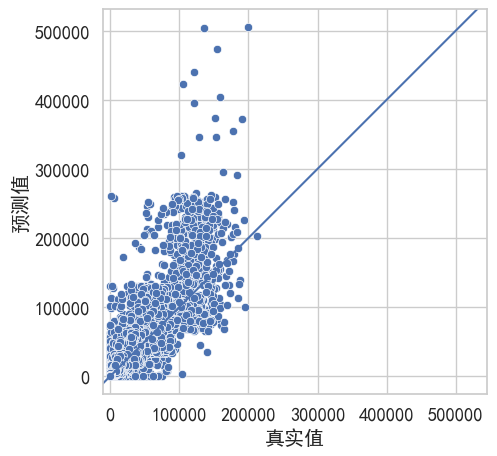

r2 0.7903995910464967
mse 12408113.717060212
mae 477.6087885545487
mape 0.8252268615772151


In [6]:

modelPath = 'LSTM.7.h5'


# 定义自定义指标函数
def r_square(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))


if not os.path.exists(modelPath):
    # 定义和训练LSTM模型
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, input_shape=(look_back, trainX.shape[2]), return_sequences=True),
        tf.keras.layers.LSTM(128 * 2),
        tf.keras.layers.Dense(1)
    ])

    metrics = r_square
    metricsName = metrics.__name__
    model.compile(loss='mse', optimizer='adam', metrics=[metrics])
    # epochs=3000, batch_size=5000
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=10000)
    model.save(modelPath)

    # 绘制学习曲线
    loss = pd.DataFrame({'训练集损失': history.history['loss'], '测试集损失': history.history['val_loss'], })
    acc = pd.DataFrame(
        {'训练集准确率': history.history[metricsName], '测试集准确率': history.history[f'val_{metricsName}'], })

    sns.lineplot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    # 绘制最后一个点并添加横线
    last_loss = history.history['loss'][-1]
    plt.plot(len(history.history['loss']) - 1, last_loss, marker='o', color='darkred')
    plt.axhline(y=last_loss, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(loss) - 20, last_loss + 0.1, f'训练集y={last_loss:.4f}', color='darkred')
    # 绘制最后一个点并添加横线
    last_loss = history.history['val_loss'][-1]
    plt.plot(len(history.history['val_loss']) - 1, last_loss, marker='o', color='darkred')
    plt.axhline(y=last_loss, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(loss) - 20, last_loss + 0.1, f'测试集y={last_loss:.4f}', color='darkred')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('损失率随训练代数的变化.svg')
    plt.show()

    sns.lineplot(acc)
    plt.xlabel('Epochs')
    plt.ylabel('R2')
    # 绘制最后一个点并添加横线
    last_acc = history.history[metricsName][-1]
    plt.plot(len(history.history[metricsName]) - 1, last_acc, marker='o', color='darkred')
    plt.axhline(y=last_acc, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(acc) - 20, last_acc + 0.1, f'训练集y={last_acc:.4f}', color='darkred')
    # 绘制最后一个点并添加横线
    last_acc = history.history[f'val_{metricsName}'][-1]
    plt.plot(len(history.history[f'val_{metricsName}']) - 1, last_acc, marker='o', color='darkred')
    plt.axhline(y=last_acc, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(acc) - 20, last_acc - 0.1, f'测试集y={last_acc:.4f}', color='darkred')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('准确率随训练代数的变化.svg')
    plt.show()

else:
    # 加载模型并继续训练
    model = tf.keras.models.load_model(modelPath, custom_objects={'r_square': r_square})

# 测试模型
y_pred = model.predict(trainX, batch_size=10000)

# 绘制预测结果和真实值的比较图
plt.figure(figsize=(16, 9))
plt.plot(np.exp(trainY), label='真实值')
plt.plot(np.exp(y_pred), label='预测值')
plt.ylabel('货量')
plt.xlabel('数据序号')
plt.legend()
plt.tight_layout()
plt.savefig('绘制预测结果和真实值的比较图.svg')
plt.show()

# y预测值-x真实值
sns.scatterplot({'预测值': np.exp(trainY), '真实值': np.exp(y_pred.reshape(len(y_pred)))}, x='真实值', y='预测值')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-1e10, 1e10], [-1e10, 1e10])
plt.tight_layout()
plt.savefig('y预测值-x真实值.svg')
plt.savefig('y预测值-x真实值.png')
plt.show()

print('r2', r2_score(np.exp(trainY), np.exp(y_pred)))
print('mse', mean_squared_error(np.exp(trainY), np.exp(y_pred)))
print('mae', mean_absolute_error(np.exp(trainY), np.exp(y_pred)))
print('mape', mean_absolute_percentage_error(np.exp(trainY), np.exp(y_pred)))

In [7]:

'''
敏感性分析
'''
# explainerData = np.copy(trainX)
# np.random.shuffle(trainX)
# explainerData = explainerData[:1000]
# explainer = shap.DeepExplainer(model, explainerData)
# shap_values = explainer.shap_values(explainerData)
# #
# # # plt.figure(figsize=(8, 6))
# # # shap.plots.waterfall(shap_values[0][:, 0, :], show=False)
# # # plt.tight_layout()
# # # plt.savefig('灵敏度瀑布图.svg')
# # # plt.show()
# # #
# # # plt.figure(figsize=(8, 6))
# # # shap.plots.bar(shap_values, show=False)
# # # plt.tight_layout()
# # # plt.savefig('灵敏度条形图.svg')
# # # plt.show()
# #
# #
# plt.figure(figsize=(16, 9))
# shap.summary_plot(shap_values[0][:, 0, :], explainerData[:][:, 0, :], data.columns[[0, 1, 3]], show=False, )
# plt.tight_layout()
# plt.savefig('灵敏度蜂群图.svg')
# plt.show()


'\n敏感性分析\n'

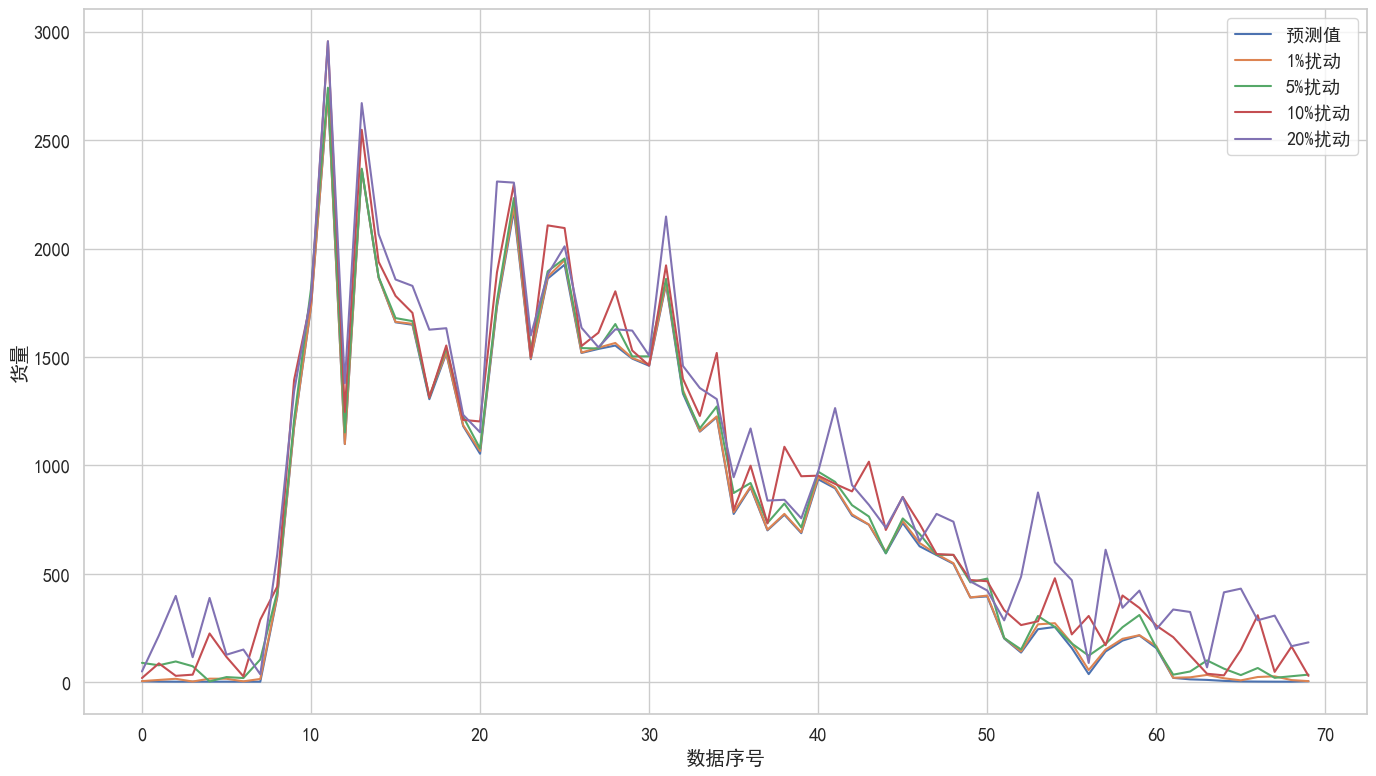

In [39]:
# 鲁棒性

# 绘制预测结果和真实值的比较图
plt.figure(figsize=(14, 8))
# plt.plot(np.exp(trainY)[19030:19100], label='真实值')
test = np.exp(y_pred)[19030:19100]
plt.plot(test, label='预测值')
plt.plot(test + np.abs(np.random.normal(0, 10, size=test.shape)), label='1%扰动')
plt.plot(test + np.abs(np.random.normal(0, 50, size=test.shape)), label='5%扰动')
plt.plot(test + np.abs(np.random.normal(0, 150, size=test.shape)), label='10%扰动')
plt.plot(test + np.abs(np.random.normal(0, 200, size=test.shape)), label='20%扰动')
plt.ylabel('货量')
plt.xlabel('数据序号')
plt.legend()
plt.tight_layout()
plt.savefig('鲁棒性.svg')
plt.show()

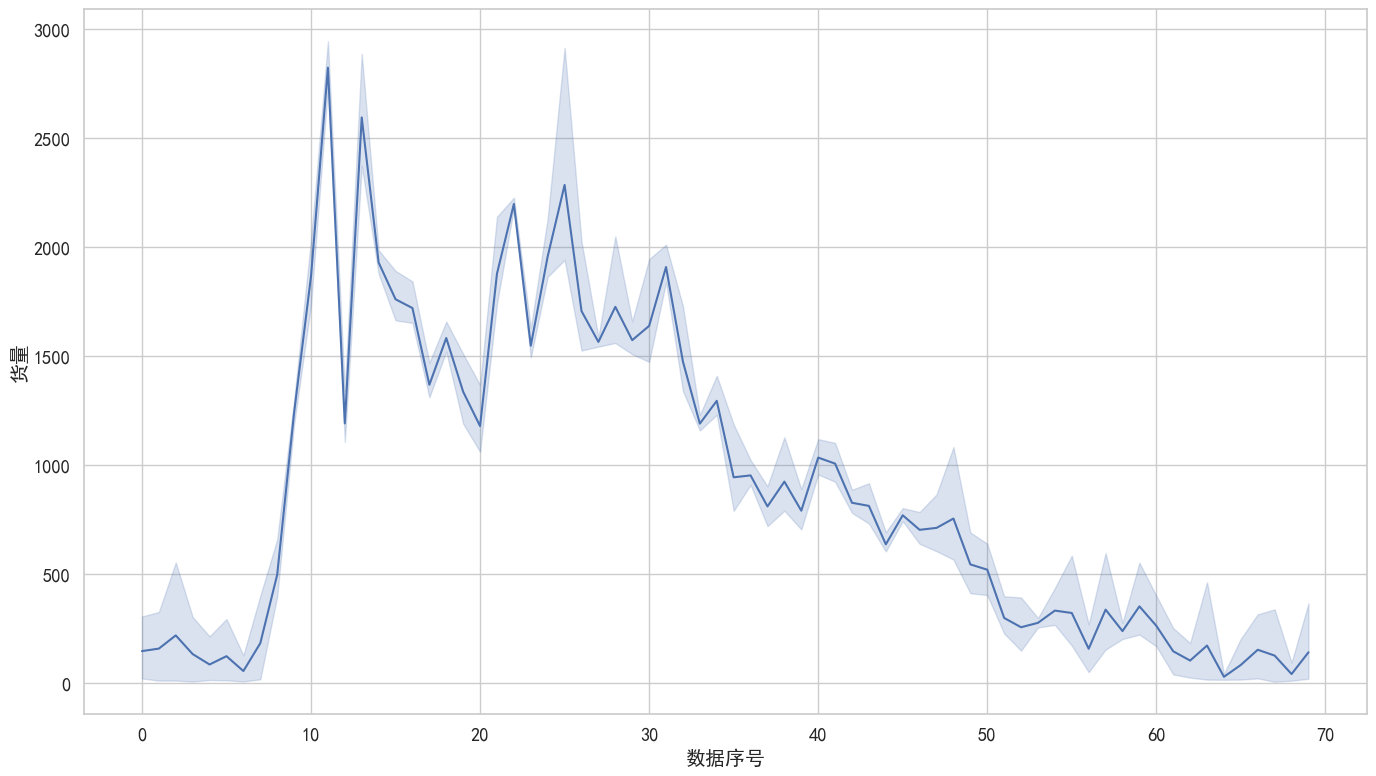

In [134]:
test = np.exp(y_pred)[19030:19100]
test2Df = pd.DataFrame(columns=['idx', 'val'])
for idx, item in enumerate(zip(
        test,
        test + np.abs(np.random.normal(0, 10, size=test.shape)),
        test + np.abs(np.random.normal(0, 50, size=test.shape)),
        test + np.abs(np.random.normal(0, 150, size=test.shape)),
        test + np.abs(np.random.normal(0, 500, size=test.shape)),
)):
    for i in item:
        test2Df.loc[len(test2Df)] = {'idx': int(idx), 'val': i[0]}

plt.figure(figsize=(14, 8))
sns.lineplot(test2Df, x='idx', y='val')
plt.ylabel('货量')
plt.xlabel('数据序号')
plt.tight_layout()
plt.savefig('鲁棒性1-2.svg')
plt.show()

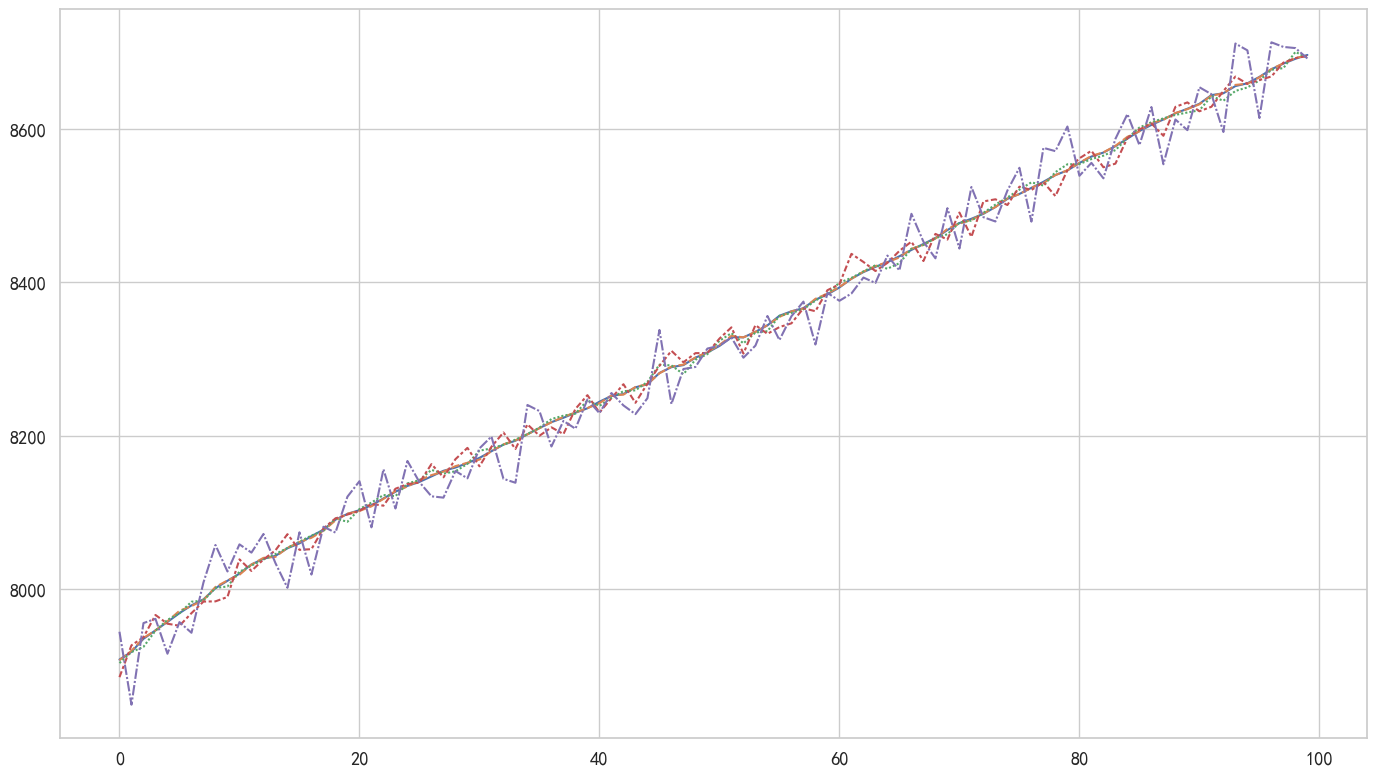

In [98]:
# 鲁棒性

# 绘制预测结果和真实值的比较图
plt.figure(figsize=(14, 8))
# plt.plot(np.exp(trainY)[19030:19100], label='真实值')
offset = 1
test = np.exp(y_pred)[300000 + offset:300100 + offset]
test2 = np.hstack([
    test,
    test + (np.random.normal(0, 1, size=test.shape)),
    test + (np.random.normal(0, 5, size=test.shape)),
    test + (np.random.normal(0, 15, size=test.shape)),
    test + (np.random.normal(0, 30, size=test.shape)),
])
sns.lineplot(test2, legend=None)
plt.tight_layout()
plt.savefig('鲁棒性2.svg')
plt.show()

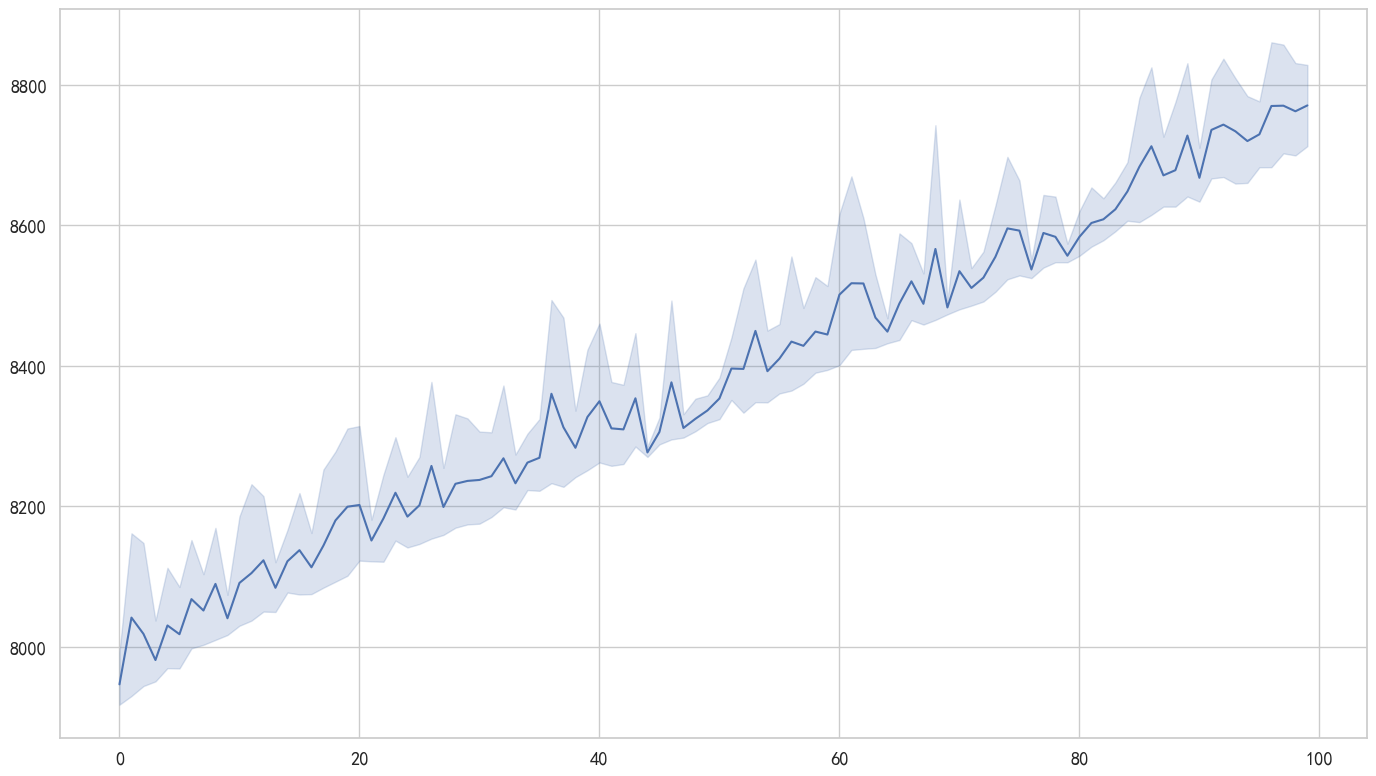

In [132]:
test = np.exp(y_pred)[300000 + offset:300100 + offset]
test2Df = pd.DataFrame(columns=['idx', 'val'])

for idx, item in enumerate(zip(
        test,
        test + np.abs(np.random.normal(0, 10, size=test.shape)),
        test + np.abs(np.random.normal(0, 50, size=test.shape)),
        test + np.abs(np.random.normal(0, 150, size=test.shape)),
        test + np.abs(np.random.normal(0, 200, size=test.shape)),
)):
    for i in item:
        test2Df.loc[len(test2Df)] = {'idx': int(idx), 'val': i[0]}

plt.figure(figsize=(14, 8))
sns.lineplot(test2Df, x='idx', y='val')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('鲁棒性2-2.svg')
plt.show()